# Analyzing Accident Severity Data in Seattle (2014-2020)

This project centers around automobile accident severity data in Seattle from the years 2014 to the present. The data was sourced from Coursera, and was provided by the Seattle Police Department. I originally created this notebook for Coursera's IBM Data Science Professional Certificate capstone project.

We will use the provided data to try and determine which factors, like road condition, lighting conditions, time of day, and location, contribute most to accident severity.

We will also use this to construct a predictive model that outputs an accident severity label from 1 to 3 (3 being the most severe), given a set of inputs related to driving conditions.

We will first load and examine the data:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('Desktop/collisions.csv')
print(df.shape)
df.head()

(194673, 38)


C:\Users\Aryan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


This dataset contains many features that are irrelevant to our model, so we will select only the columns that we deem to be useful. We will also examine all the unique values within these columns.

In [3]:
X = df[['SEVERITYCODE', 'ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]

print(X['ADDRTYPE'].value_counts())
print(X['WEATHER'].value_counts())
print(X['ROADCOND'].value_counts())
print(X['LIGHTCOND'].value_counts())

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64
Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64
Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64
Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off 

We have a mutlitude of "Unknown" and "Other" values which will not be useful to our model. We will drop these values.

In [4]:
X.drop(X.loc[X['WEATHER'] == 'Unknown'].index, inplace=True)
X.drop(X.loc[X['WEATHER'] == 'Other'].index, inplace=True)

X.drop(X.loc[X['ROADCOND'] == 'Unknown'].index, inplace=True)
X.drop(X.loc[X['ROADCOND'] == 'Other'].index, inplace=True)

X.drop(X.loc[X['LIGHTCOND'] == 'Unknown'].index, inplace=True)
X.drop(X.loc[X['LIGHTCOND'] == 'Other'].index, inplace=True)
X.drop(X.loc[X['LIGHTCOND'] == 'Dark - Unknown Lighting'].index, inplace=True)

C:\Users\Aryan\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We will now check to see that the values were indeed removed.

In [5]:
print(X['ADDRTYPE'].value_counts())
print(X['WEATHER'].value_counts())
print(X['ROADCOND'].value_counts())
print(X['LIGHTCOND'].value_counts())

Block           110918
Intersection     62869
Alley              601
Name: ADDRTYPE, dtype: int64
Clear                       108948
Raining                      32672
Overcast                     26953
Snowing                        831
Fog/Smog/Smoke                 553
Sleet/Hail/Freezing Rain       107
Blowing Sand/Dirt               47
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64
Dry               121689
Wet                46373
Ice                 1083
Snow/Slush           837
Standing Water       105
Sand/Mud/Dirt         66
Oil                   60
Name: ROADCOND, dtype: int64
Daylight                    112673
Dark - Street Lights On      46813
Dusk                          5661
Dawn                          2413
Dark - No Street Lights       1409
Dark - Street Lights Off      1120
Name: LIGHTCOND, dtype: int64


We will now check to see if any null values exist. If so, we will drop them.

In [6]:
print(X.shape)

print(X.isna().sum())
X.dropna(inplace = True)
X.head()

(175208, 5)
SEVERITYCODE       0
ADDRTYPE         820
WEATHER         5067
ROADCOND        4995
LIGHTCOND       5119
dtype: int64


C:\Users\Aryan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,SEVERITYCODE,ADDRTYPE,WEATHER,ROADCOND,LIGHTCOND
0,2,Intersection,Overcast,Wet,Daylight
1,1,Block,Raining,Wet,Dark - Street Lights On
2,1,Block,Overcast,Dry,Daylight
3,1,Block,Clear,Dry,Daylight
4,2,Intersection,Raining,Wet,Daylight


Since our data is categorical, we would like to convert it to numerical values so it may be interpreted by our machine learning algorithms. We will do this using Sklearn's LabelEncoder, which simply assigns a numeric label to a category.

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X.ADDRTYPE = le.fit_transform(X.ADDRTYPE)
X.WEATHER = le.fit_transform(X.WEATHER)
X.ROADCOND = le.fit_transform(X.ROADCOND)
X.LIGHTCOND = le.fit_transform(X.LIGHTCOND)

X.head()

C:\Users\Aryan\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,SEVERITYCODE,ADDRTYPE,WEATHER,ROADCOND,LIGHTCOND
0,2,2,3,6,4
1,1,1,5,6,2
2,1,1,3,0,4
3,1,1,1,0,4
4,2,2,5,6,4


We will now split the dataframe into our X and y datasets to be processed by the algorithm. We select the features from the dataframe and store them into X_arr as a numpy array using '.values', and we will store the target labels of the dataframe as a numpy array into y.

In [8]:
X_arr = X[['ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']].values
y = X.SEVERITYCODE.values
y

array([2, 1, 1, ..., 2, 2, 1], dtype=int64)

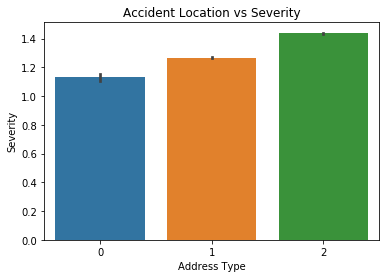

In [9]:
ax = sns.barplot(data = X, x = 'ADDRTYPE', y = 'SEVERITYCODE')
ax.set(xlabel = 'Address Type', ylabel = 'Severity', title = 'Accident Location vs Severity')
ax.set_xticklabels({0:'Alley', 1:'Block', 2:'Intersesction'})
plt.show()

The drawback of Label Encoding our categorical data is that it may be misinterpreted by our algorithm. For example, say in the LIGHTCOND column, the category of "Dusk" is given a label of 6, and the category of "Dark" is given a label of 1. Obviously, the Dusk category does not hold 6 times more weight than the night category, right? To rectify this, we normalize the data using Sklearn's Standard Scaler.

In [10]:
from sklearn import preprocessing
X_arr = preprocessing.StandardScaler().fit(X_arr).transform(X_arr.astype(float))

We will now split the dataset up into testing and training sets.

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_arr, y, test_size=0.15, random_state=4)

We will try a Support Vector Machine for this multiclass classification problem.

In [12]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)



As this is a multiclass classification, it is appropriate to use F1 score as an evaluation metric, as it takes into account the distribution of the data, rather than a simple accuracy score.

In [13]:
from sklearn.metrics import f1_score
print(f1_score(y_test, yhat))

0.8077212098440729


Since F1 scores range from 0.0 to 1.0, this is quite decent. This means that our model was able to predict 80.77% of the change within the data points using the features we selected, which suggests that our model is fairly accurate indeed.

Now, if we wanted to predict the severity of an accident with certain light and road conditions, we could create a numpy array containing those characteristics, feed it into the model with clf.predict(array_name), and then print out the result. This concludes the notebook!